I have decided to move forward on Problem B: Predict the next week's outgoing given the past 3 months (12 weeks) - for the following reasons:
- Aggregating data by week allows to see more seasonality compared to a month aggregation. In one hand, we are allowed to use 12 weeks == 3 months. Hence we might see some seasonality over the first week of each month, or the last. In the other hand we are allowed to use only 6 months, so we can't anticipate some obvious incomes like end of the year bonuses of yearly salary increase...
- We have more expenses data (16406 compared to 2439 for incomes)
- Having a week without any expense in a group of 12 weeks may be less impactful than having a month without income in a group of 6 months.

In [5]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import pandas as pd

pd.set_option("display.max_rows", 500)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
df_accounts = pd.read_csv(
    "../data/accounts_enough_history.csv", parse_dates=["update_date"]
)
df_transactions = pd.read_csv(
    "../data/transactions_enough_history.csv", parse_dates=["date"]
)

<IPython.core.display.Javascript object>

In [8]:
#df_transactions = df_transactions[df_transactions["amount"] < 0]
df_transactions["amount"] = abs(df_transactions["amount"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Expenses values
Let us take an `example` and see if it's necessary to remove outliers

<AxesSubplot:xlabel='amount', ylabel='Density'>

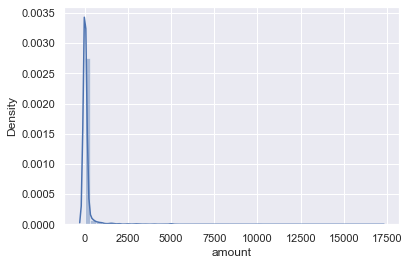

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
sns.distplot(df_transactions["amount"])

In [11]:
df_transactions[df_transactions["amount"] > 15000]

,account_id,amount,date
16595,46,17040.0,2019-11-18


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
df_transactions_46 = df_transactions[df_transactions["account_id"] == 46]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
print(f"Mean expense: {df_transactions_46['amount'].mean()}")
print(f"Median expense: {df_transactions_46['amount'].median()}")
print(f"Standard deviation expense: {df_transactions_46['amount'].std()}")

Mean expense: 190.44159944367178
Median expense: 18.8
Standard deviation expense: 994.437154908764


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Having an expense of 17040.0 seems to be way to high 

Let us see if this expense is seasonal and can be predicted, or if it's only a specific expense that might never happen again.

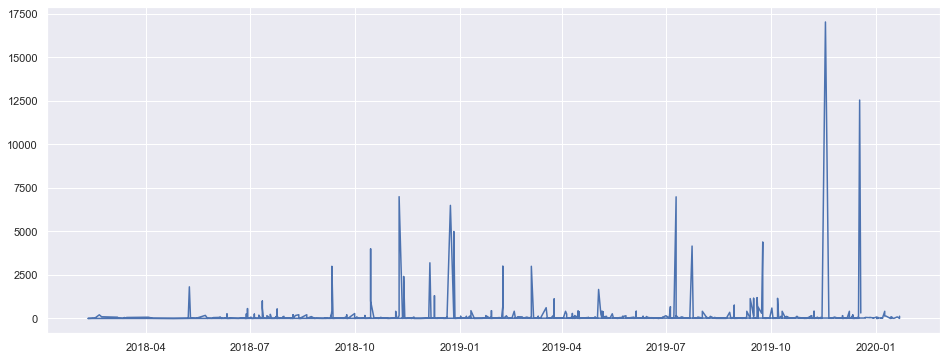

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(df_transactions_46["date"], df_transactions_46["amount"])

We observe that high expenses (compared to neighbouring ones) appear mostly at the end of the year (here at the end of 2018 and 2019).

Since we are not allowed to take that much data (only 12 previous weeks), these high expenses seem to be outliers.

Removing outliers:
For a matter of simplicity (and speed): for each month, I will look at the mean and std of expenses, and remove expenses that are higher than the `mean + 3 * std`. I will then see how many data to I remove.

In [31]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["year_month"] = df["year"].astype("str") + "_" + df["month"].map("{:02}".format)

    df_month_expenses = (
        df.groupby(["account_id", "year_month"])["amount"]
        .agg(["mean", "std"])
        .reset_index()
    )
    df = pd.merge(
        df,
        df_month_expenses,
        on=["account_id", "year_month"],
        how="left",
        sort=False,
    )
    df["outlier"] = df["amount"] > (df["mean"] + 3 * df["std"])
    return df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
df_transactions_46 = remove_outliers(df=df_transactions_46)
df_transactions_46.head()

,account_id,amount,date,year,month,year_month,mean,std,outlier
0,46,315.42,2019-12-19,2019,12,2019_12,389.186486,2057.295731,False
1,46,12553.76,2019-12-18,2019,12,2019_12,389.186486,2057.295731,True
2,46,6.40,2019-12-17,2019,12,2019_12,389.186486,2057.295731,False
3,46,20.79,2019-12-16,2019,12,2019_12,389.186486,2057.295731,False
4,46,7.30,2019-12-16,2019,12,2019_12,389.186486,2057.295731,False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
print(
    f"{df_transactions_46['outlier'].sum() / len(df_transactions_46) * 100} % Outliers"
)

3.05980528511822 % Outliers


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
df_transactions_46[df_transactions_46["outlier"] == True]

,account_id,amount,date,year,month,year_month,mean,std,outlier
1,46,12553.76,2019-12-18,2019,12,2019_12,389.186486,2057.295731,True
35,46,17040.00,2019-11-18,2019,11,2019_11,467.242000,2688.528447,True
94,46,1159.00,2019-10-07,2019,10,2019_10,81.321395,200.052545,True
122,46,4397.00,2019-09-24,2019,9,2019_09,257.703590,753.342690,True
151,46,760.00,2019-08-30,2019,8,2019_08,80.763214,165.422343,True
200,46,6991.13,2019-07-10,2019,7,2019_07,422.590625,1405.453672,True
237,46,414.00,2019-06-05,2019,6,2019_06,47.589091,73.876129,True
275,46,1668.00,2019-05-03,2019,5,2019_05,121.545263,275.978373,True
335,46,3000.00,2019-03-05,2019,3,2019_03,224.068519,605.965606,True
359,46,3000.00,2019-02-08,2019,2,2019_02,193.903103,560.315164,True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

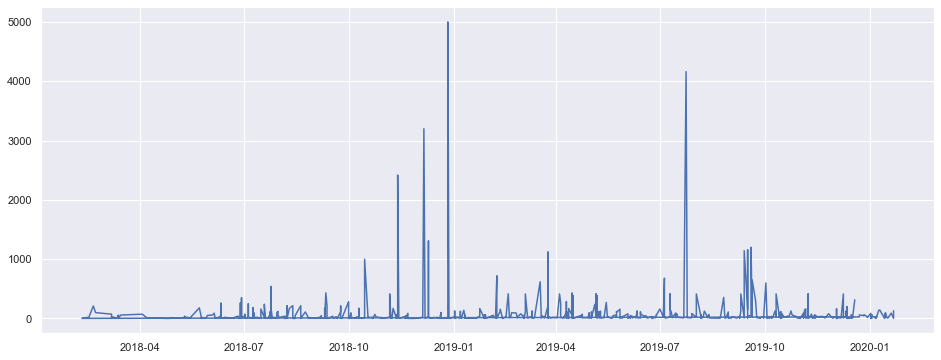

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
df_transactions_46_no_outliers = df_transactions_46[
    df_transactions_46["outlier"] == False
]
plt.figure(figsize=(16, 6))
plt.plot(
    df_transactions_46_no_outliers["date"], df_transactions_46_no_outliers["amount"]
)

Indeed we removed the very high expenses and only a very small amount of expenses, but we also removed some small ones and that cannot be considered as outliers.

#### Let us look when we apply this function to the whole dataframe

In [45]:
df_no_outliers = remove_outliers(df=df_transactions)
df_no_outliers.head()

,account_id,amount,date,year,month,year_month,mean,std,outlier
0,2,60.0,2019-12-04,2019,12,2019_12,25.756667,19.206179,False
1,2,10.5,2019-11-30,2019,11,2019_11,14.095000,12.218542,False
2,2,4.7,2019-11-29,2019,11,2019_11,14.095000,12.218542,False
3,2,15.0,2019-11-29,2019,11,2019_11,14.095000,12.218542,False
4,2,1.6,2019-11-27,2019,11,2019_11,14.095000,12.218542,False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
print(f"{df_no_outliers['outlier'].sum() / len(df_no_outliers) * 100} % Outliers")

2.450323052541753 % Outliers


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- We only removed 2.45% of data

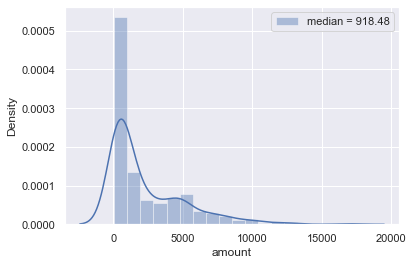

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
sns.distplot(df_no_outliers[df_no_outliers["outlier"] == True]["amount"], 
             label = f"median = {df_no_outliers[df_no_outliers['outlier'] == True]['amount'].median()}")
plt.legend()


We observe that the 2.45% of data contains many low values that can be kept.
We might keep this way of filtering and consider that we only remove few data. But let us see how the outliers removal works if we aggregate by year instead of by month.

In [49]:
def remove_outliers_year_aggregation(df: pd.DataFrame) -> pd.DataFrame:
    df["year"] = df["date"].dt.year

    df_month_expenses = (
        df.groupby(["account_id", "year"])["amount"].agg(["mean", "std"]).reset_index()
    )
    df = pd.merge(
        df,
        df_month_expenses,
        on=["account_id", "year"],
        how="left",
        sort=False,
    )
    df["outlier"] = df["amount"] > (df["mean"] + 3 * df["std"])
    return df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
df_no_outliers_year_agg = remove_outliers_year_aggregation(df=df_transactions)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
print(
    f"{df_no_outliers_year_agg['outlier'].sum() / len(df_no_outliers_year_agg) * 100} % Outliers"
)

1.8712666097769108 % Outliers


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

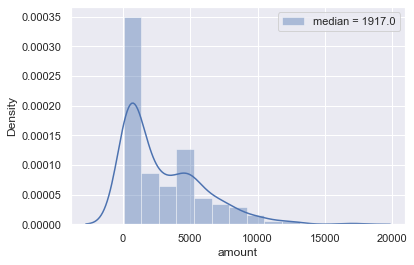

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
sns.distplot(
    df_no_outliers_year_agg[df_no_outliers_year_agg["outlier"] == True]["amount"],
    label=f"median = {df_no_outliers_year_agg[df_no_outliers_year_agg['outlier'] == True]['amount'].median()}",
)
plt.legend()

Here we get a higher median, which may be better. 

Let check again by looking at account 46

In [62]:
df_transactions_46 = df_transactions[df_transactions["account_id"] == 46]
df_transactions_46 = remove_outliers_year_aggregation(df=df_transactions_46)
df_transactions_46[df_transactions_46["outlier"] == True]

,account_id,amount,date,year,month,year_month,mean,std,outlier
1,46,12553.76,2019-12-18,2019,12,2019_12,201.477136,1138.779909,True
35,46,17040.00,2019-11-18,2019,11,2019_11,201.477136,1138.779909,True
122,46,4397.00,2019-09-24,2019,9,2019_09,201.477136,1138.779909,True
184,46,4162.00,2019-07-24,2019,7,2019_07,201.477136,1138.779909,True
200,46,6991.13,2019-07-10,2019,7,2019_07,201.477136,1138.779909,True
420,46,5000.00,2018-12-27,2018,12,2018_12,185.564157,771.198296,True
422,46,6500.00,2018-12-24,2018,12,2018_12,185.564157,771.198296,True
441,46,3200.00,2018-12-06,2018,12,2018_12,185.564157,771.198296,True
459,46,7000.00,2018-11-09,2018,11,2018_11,185.564157,771.198296,True
482,46,4000.00,2018-10-15,2018,10,2018_10,185.564157,771.198296,True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here we see that we remove mainly the very high values.

`I will hence use the outliers removal function that aggregates by year: *remove_outliers_year_aggregation*` 

In [67]:
# Save new dataset
df_no_outliers_year_agg[df_no_outliers_year_agg["outlier"] == False].to_csv(
    "../data/transactions_no_outliers.csv", index=False
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>